In [22]:
import os
from fastai import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from fastbook import *
import torch
import numpy as np
import random
from fastai.data.core import DataLoaders

In [3]:
phone_types = 'samsung','apple','huawei','nokia','sony'
path = Path('phones')
key = os.environ.get('AZURE_SEARCH_KEY', '1d6926543349403091078f8b44094a81')

In [4]:
path

Path('phones')

In [5]:
fns = get_image_files(path)
fns

(#499) [Path('phones/samsung/00000140.jpg'),Path('phones/samsung/00000058.jpg'),Path('phones/samsung/00000072.jpg'),Path('phones/samsung/00000045.jpg'),Path('phones/samsung/00000137.jpg'),Path('phones/samsung/00000069.jpg'),Path('phones/samsung/00000078.jpg'),Path('phones/samsung/00000044.jpg'),Path('phones/samsung/00000075.jpeg'),Path('phones/samsung/00000125.jpg')...]

In [6]:
for o in phone_types:
    for image in os.listdir(path/o):
        ext = os.path.splitext(image)[1]     
        if ext in ['.png', '.gif']:
            new_filename = str(path/o)+"/" + os.path.splitext(image)[0]+'.png'
            img = Image.open(path/o/image)
            #os.remove(str(path/o)+ "/" + image)
            img.convert('RGBA')
            img.save(new_filename)
            print('saving: ' + new_filename)

In [7]:
files = get_image_files(path)
files[140]

Path('phones/huawei/00000055.jpg')

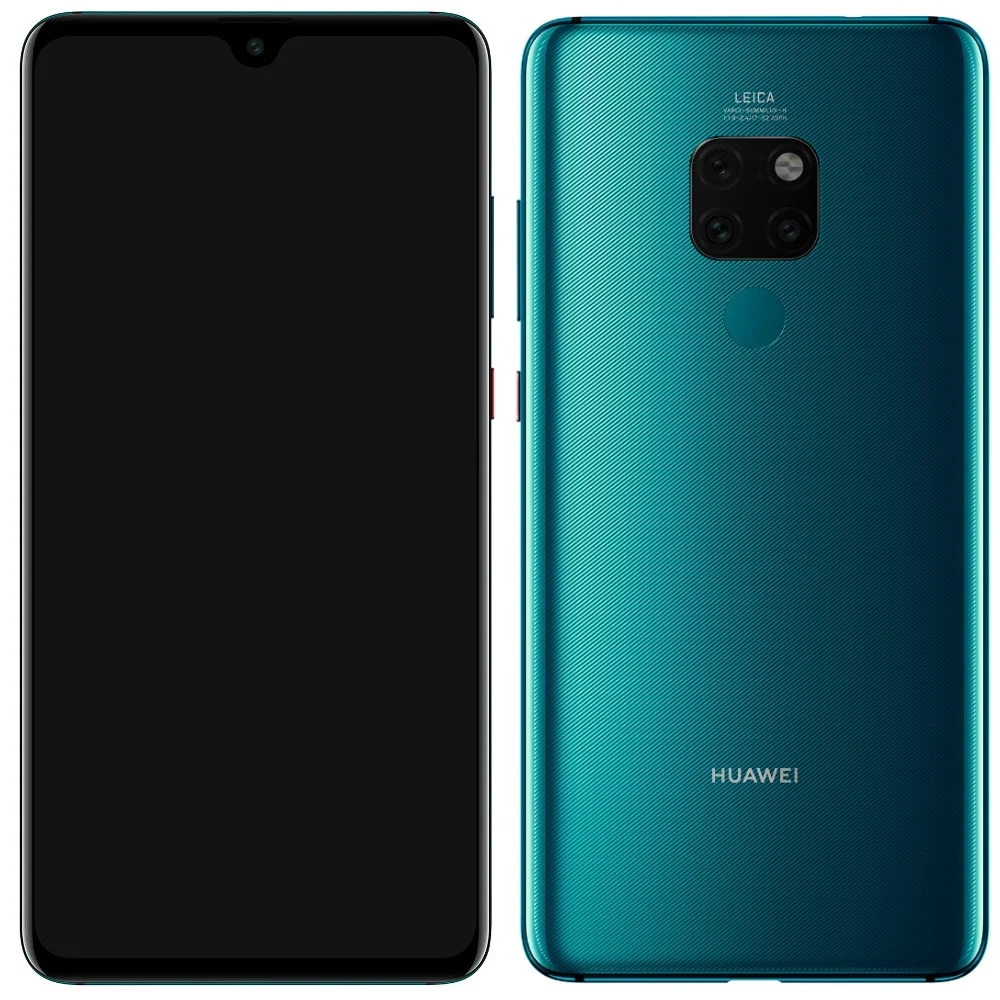

In [8]:
import PIL
img = PIL.Image.open(files[140])
img

In [9]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [10]:
open_image(files[0]).shape

torch.Size([3, 224, 224])

In [11]:
def label_func(fname):
    return str(fname).split('/')[1]

label_func(files[0])

'samsung'

In [12]:
labels = list(set(files.map(label_func)))
len(labels)

5

In [17]:
lbl2files = {l: [f for f in files if label_func(f) == l] for l in labels}

In [18]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [20]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

In [21]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files, is_valid=True)

In [23]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [24]:
b = dls.one_batch()

In [25]:
dls = dls.cuda()

In [27]:
class SiameseTransform(Transform):
    def __init__(self, files, is_valid=False):
        self.files,self.is_valid = files,is_valid
        if is_valid: self.files2 = [self._draw(f) for f in files]
        
    def encodes(self, i):
        file1 = self.files[i]
        (file2,same) = self.files2[i] if self.is_valid else self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (TensorImage(img1), TensorImage(img2), torch.Tensor([same]).squeeze())
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(lbl2files[cls]),same

In [29]:
train_tl= TfmdLists(range(len(train_files)), SiameseTransform(train_files))
valid_tl= TfmdLists(range(len(valid_files)), SiameseTransform(valid_files, is_valid=True))

In [31]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [32]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

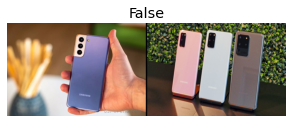

In [33]:
img = PILImage.create(files[0])
img1 = PILImage.create(files[1])
s = SiameseImage(img, img1, False)
s.show();

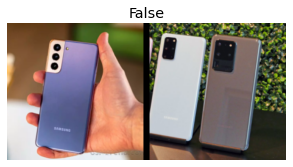

In [34]:
tst = Resize(224)(s)
tst = ToTensor()(tst)
tst.show();

In [35]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [36]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)

In [37]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

In [38]:
tls = TfmdLists(files, tfm, splits=splits)


<AxesSubplot:title={'center':'True'}>

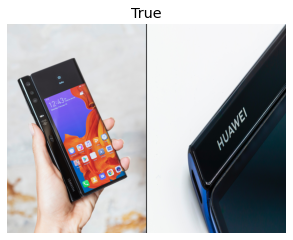

In [46]:
show_at(tls.valid, 2)


In [40]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [41]:
b = dls.one_batch()
type(b)

__main__.SiameseImage

In [43]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [44]:
b = dls.one_batch()

In [48]:
dls._types

{__main__.SiameseImage: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  torch.Tensor]}

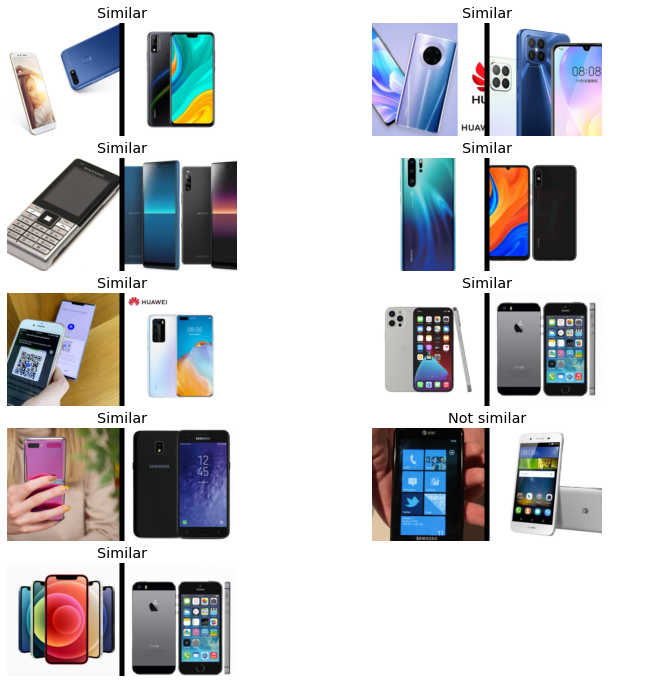

In [49]:
dls.show_batch()

In [50]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [52]:
img = ImageTuple.create((files[0], files[1]))
tst = ToTensor()(img)
type(tst[0]),type(tst[1])

(fastai.torch_core.TensorImage, fastai.torch_core.TensorImage)

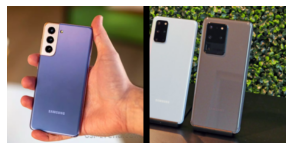

In [53]:
img1 = Resize(224)(img)
tst = ToTensor()(img1)
tst.show();

In [54]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [56]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [57]:
def get_split(f):
    for i,s in enumerate(splits_sets):
        if f in s: return i
    raise ValueError(f'File {f} is not presented in any split.')
splbl2files = [{l: [f for f in s if label_func(f) == l] for l in labels} for s in splits_sets]
def splitter(items): 
    def get_split_files(i): return [j for j,(f1,f2,same) in enumerate(items) if get_split(f1)==i]
    return get_split_files(0),get_split_files(1)
def draw_other(f):
    same = random.random() < 0.5
    cls = label_func(f)
    split = get_split(f)
    if not same: cls = random.choice(L(l for l in labels if l != cls)) 
    return random.choice(splbl2files[split][cls]),same
def get_tuples(files): return [[f, *draw_other(f)] for f in files]

In [59]:
def get_x(t): return t[:2]
def get_y(t): return t[2]
siamese = DataBlock(
    blocks=(ImageTupleBlock, CategoryBlock),
    get_items=get_tuples,
    get_x=get_x, get_y=get_y,
    splitter=splitter,
    item_tfms=Resize(224),
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)
dls = siamese.dataloaders(files)

In [60]:
b = dls.one_batch()
explode_types(b)

{tuple: [{__main__.ImageTuple: [fastai.torch_core.TensorImage,
    fastai.torch_core.TensorImage]},
  fastai.torch_core.TensorCategory]}

In [61]:
@typedispatch
def show_batch(x:ImageTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    ctxs = show_batch[object](x, y, samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

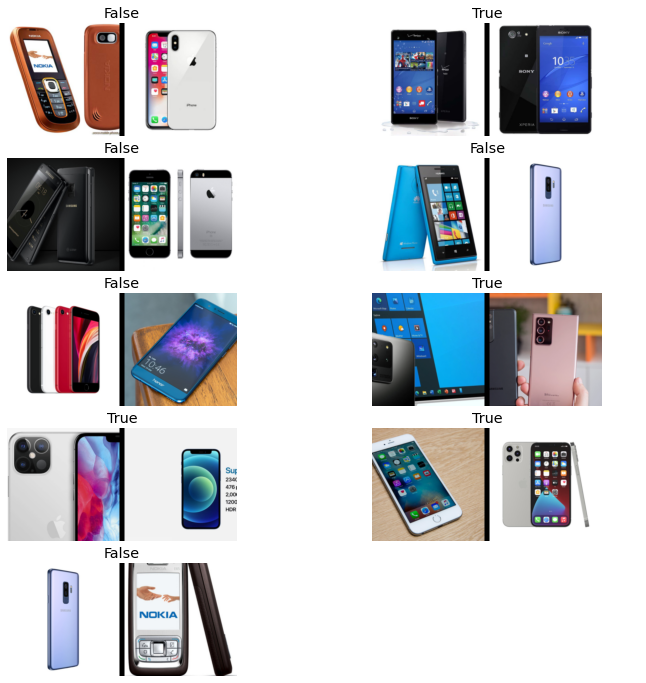

In [62]:
dls.show_batch()

In [63]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [64]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

In [65]:
encoder = create_body(resnet34, cut=-2)

In [66]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [68]:
head = create_head(512*2, 2, ps=0.5)
model = SiameseModel(encoder, head)

In [70]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [72]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [74]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [76]:
class SiameseTransform(Transform):
    def __init__(self, files, splits):
        self.splbl2files = [{l: [f for f in files[splits[i]] if label_func(f) == l] for l in labels}
                          for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
    def encodes(self, f):
        f2,same = self.valid.get(f, self._draw(f,0))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, int(same))
    
    def _draw(self, f, split=0):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice(L(l for l in labels if l != cls)) 
        return random.choice(self.splbl2files[split][cls]),same

In [78]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [80]:
valids = [v[0] for k,v in tfm.valid.items()]      
assert not [v for v in valids if v in files[splits[0]]]

In [84]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), splitter=siamese_splitter, metrics=error_rate)

In [85]:
learn.freeze()

SuggestedLRs(valley=9.120108734350652e-05)

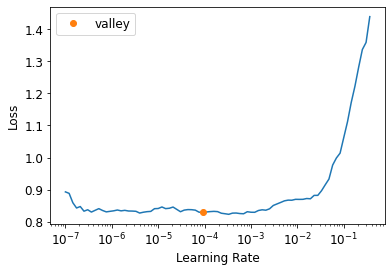

In [86]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(9, 9e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.865656,0.685534,0.515152,00:28
1,0.856497,0.689483,0.464646,00:29
2,0.861169,0.668419,0.383838,00:30
3,0.826991,0.645693,0.383838,00:27
4,0.826735,0.640592,0.353535,00:28
5,0.841088,0.666449,0.353535,00:29
6,0.832987,0.678752,0.383838,00:30
7,0.831656,0.681940,0.404040,00:29
8,0.833801,0.681447,0.424242,00:30


In [88]:
learn.unfreeze()

In [89]:
learn.fit_one_cycle(6, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.797594,0.682278,0.383838,00:32
1,0.812131,0.690615,0.363636,00:31
2,0.792461,0.688616,0.383838,00:31
3,0.807361,0.683568,0.404040,00:31
4,0.808320,0.679858,0.414141,00:34
5,0.798544,0.680951,0.393939,00:34


In [90]:
@typedispatch
def show_results(x:SiameseImage, y, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        title = f'Actual: {["Not similar","Similar"][x[2][i].item()]} \n Prediction: {["Not similar","Similar"][y[2][i].item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

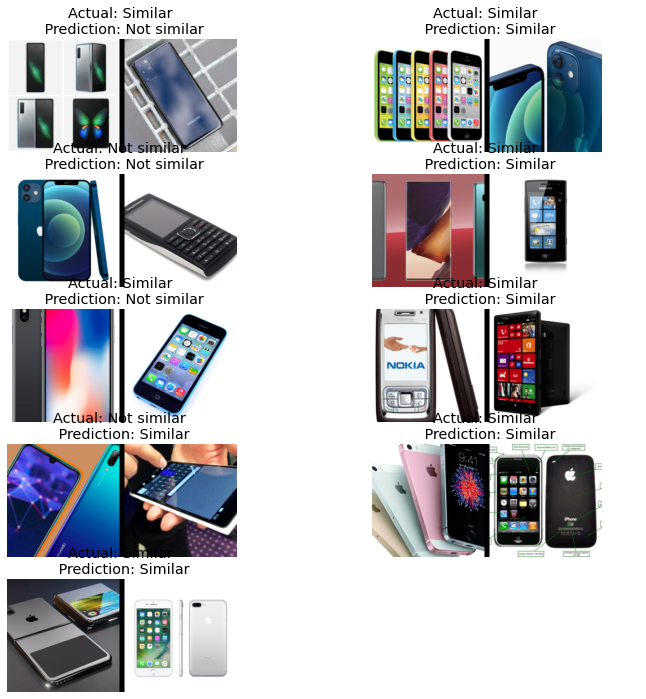

In [91]:
learn.show_results()

In [92]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

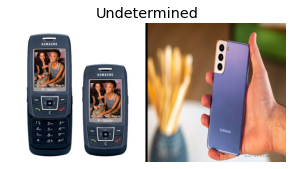

In [93]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

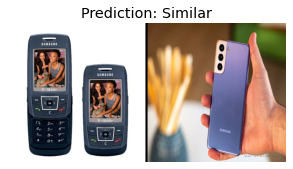

In [94]:
res = learn.siampredict(siamtest)